# Melanoma Single Slice Tutorial

- **Creator**: Amir Akbarnejad (aa36@sanger.ac.uk)
- **Affiliation**: Wellcome Sanger Institute
- **Date of Creation**: 17.02.2025
- **Date of Last Modificaion**: 17.02.2025


This notebook demonstrates analysing inflow results on the Melanoma sample from `https://www.10xgenomics.com/datasets/xenium-prime-ffpe-human-skin` with the following consideration: The decomposition of `adata.X` is unerliable for small readcounts below a threshold. So in this notebook those small readcounts are dropped in Xint and Xspl, so the values in Xint and Xspl are reliable and migth be more appropriate for further analysis.

SANGER INTERNAL: The sample is available on farm in `/nfs/team361/aa36/OnGit/inflow-reproducibility/Analysis/18_Melanoma_Jan20Runs/NonGit/Data/preprocBy_nb1_preprocessing_V3.h5ad`.




# 1. Setup and Training

This notebook assumes inigen training has already been done through the command-line interface (cli), which involes two steps
- Creating 4 config files
- Running inflow via `python inflow_cli.py ....`
  
Please refer to `https://github.com/Lotfollahi-lab/inflow` for complete information about training inflow via CLI.

Also the config files used for training are available in
`/nfs/team361/aa36/ToShare/MelanomaSampleConfigFiles/` in case you are interested to know the training parameters.

There is no need to re-run the training, because the results are already available in the following directory, and this notebook **simply reads and analyses** those results:
`/nfs/team361/aa36/OnGit/inflow-reproducibility/Analysis/18_Melanoma_Jan20Runs/NonGit/RunOutputs/Jan30_15_00_5KGenes/Output_Path_Run1`



In [1]:
# local settings (TODO:modify if needed) ===
rootdir_inflow = "../../../inflow/"  # please change this path if needed.

In [2]:
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import numpy as np
from scipy.sparse import issparse
import pandas as pd
import torch
import gc

list_pathstoadd = [
    rootdir_inflow,
    os.path.join(rootdir_inflow, "src"),
    os.path.join(rootdir_inflow, "src", "inflow")
]

for path in list_pathstoadd:
    if(path not in sys.path):
        sys.path.append(path)


import inflow
from inflow.cli import parse_config_data_train, parse_config_data_test, parse_config_training, parse_config_model


plt.rcParams.update({'font.size': 20})
plt.rcParams['font.sans-serif'] = "arial"

# 2. Preparing the Anndata for Analysis

## 2.1. Parse the config files (which are copied over by inflow to the output path)

In [3]:
# local settings (TODO:modify if needed)
path_results = \
"/nfs/team361/aa36/OnGit/inflow-reproducibility/Analysis/18_Melanoma_Jan20Runs/NonGit/RunOutputs/Jan30_15_00_5KGenes/Output_Path_Run1"

In [4]:
config_data_test = parse_config_data_test.parse(
    os.path.join(
        path_results,
        'ConfigFilesCopiedOver',
        'config_data_test.yml'
    )
)


## 2.2. Read the anndata

In [5]:
adata = sc.read_h5ad(config_data_test[0]['file'])
adata

AnnData object with n_obs × n_vars = 98227 × 3863
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'segmentation_method', 'fine_celltypes', 'broad_celltypes', 'region', 'celltype', 'DonorID', 'niche_name', 'info_id', 'Site_status', 'leiden_res1', 'leiden_res2', 'dataset_id', 'original_celltypes', 'n_counts', 'n_genes'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'final_celltypes_colors', 'leiden_res2', 'leiden_res2_colors', 'log1p', 'lvl2_annotation2', 'lvl2_annotation2_colors', 'neighbor_10', 'neighbor_50', 'original_celltypes_colors', 'umap'
    obsm: 'X_scarches', 'X_scvi', 'X_umap', 'spatial'
    layers: 'counts'
    obsp: 'neighbor_10_connectivities', 'neighbor_10_distances', 'neighbor_50_connectivities', 'neighbor_50_distances'

## 2.3. Read inflow predictions

In [6]:
dict_inflow_predictions = torch.load(
    os.path.join(
        path_results,
        'CheckpointAndPredictions',
        'predictions_slice_1.pt'
    ),
    map_location='cpu'
)

/tmp/ipykernel_779798/858127503.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dict_inflow_predictions = torch.load(


## 2.4. Place inflow predictions in `adata.obsm`

In [7]:
dict_map_prednames_2_readable = {
    'muxint':'Xint',
    'muxspl':'Xspl',
    'muxbar_int':'Xbar_int',
    'muxbar_spl':'Xbar_spl',
    'mu_sin':'S_in',
    'mu_sout':'S_out',
    'mu_z':'Z',
    'muxint_before_sc_pp_normalize_total':'Xint_without_scppnormalizetotal',
    'muxspl_before_sc_pp_normalize_total':'Xspl_without_scppnormalizetotal'
}  # to make the names more similar to the naming in the manuscript
for k in dict_inflow_predictions.keys():
    # convert from sparse to dense if needed ===
    if issparse(dict_inflow_predictions[k]):
        dict_inflow_predictions[k] = dict_inflow_predictions[k].toarray()
        
    adata.obsm['inflow_{}'.format(dict_map_prednames_2_readable[k])] = dict_inflow_predictions[k]
    

Now the following predictions are put in `adata.obsm`, which are used in the analysis below
- inflow_Xint
- inflow_Xspl
- inflow_Xbar_int
- inflow_Xbar_spl
- inflow_S_in
- inflow_S_out
- inflow_Z
- inflow_Xint_without_scppnormalizetotal
- inflow_Xspl_without_scppnormalizetotal

2.5. Row-normalise the read counts, with the same `target_sum` value used during training. 

In [8]:
config_training = parse_config_training.parse(
    os.path.join(
        path_results,
        'ConfigFilesCopiedOver',
        'config_training.yml'
    )
)
adata_unnorm = adata.copy()
sc.pp.normalize_total(adata, inplace=True, target_sum=config_training['val_scppnorm_total'])

## 2.6. Double check the consistency of row normalization

A common issue the inconsistency of row normalization, in which case the predicted `Xint` and `Xspl` do not sum up to `adata.X`.

To avoid this error, let's check if they are the same

In [9]:
rowsum_predictions = (adata.obsm['inflow_Xint'] + adata.obsm['inflow_Xspl']).sum(1)
rowsum_adata_X = np.array(adata.X.sum(1)).flatten()
print(
    "This should print a small number: {}".format(
        np.max(np.abs(rowsum_predictions - rowsum_adata_X))
    )
)

This should print a small number: 0.0048828125


## 2.7. Remove low readcounts from Xint and Xspl 

If the variable `threshold_discard_readcount` below is set to, e.g., 10, then the elements of `adata.X` which are less than or equal 10 are masked in Xint and Xspl, and the modified Xint and Xspl is used for the analysis.

In [10]:
# local settings (TODO:modify if needed) ===
threshold_discard_readcount = 10

In [11]:
flag_keep_basedon_readcount = (adata_unnorm.X.toarray() > threshold_discard_readcount) + 0
for k in [
    'inflow_Xint',
    'inflow_Xspl',
    'inflow_Xint_without_scppnormalizetotal',
    'inflow_Xspl_without_scppnormalizetotal'
]:
    adata.obsm[k] = adata.obsm[k] * flag_keep_basedon_readcount
    gc.collect()


del flag_keep_basedon_readcount
gc.collect()
gc.collect()
gc.collect()

0

# 3. Analysis

## 3.1 Rank the mostly intrinsic and the mostly spatial genes per cell type

In [12]:
# local settings (TODO:modify if needed) ===
flag_logaritmise = True
n_genes_showranking = 20

/nfs/team361/aa36/PythonEnvs_2/envinflowdec27/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


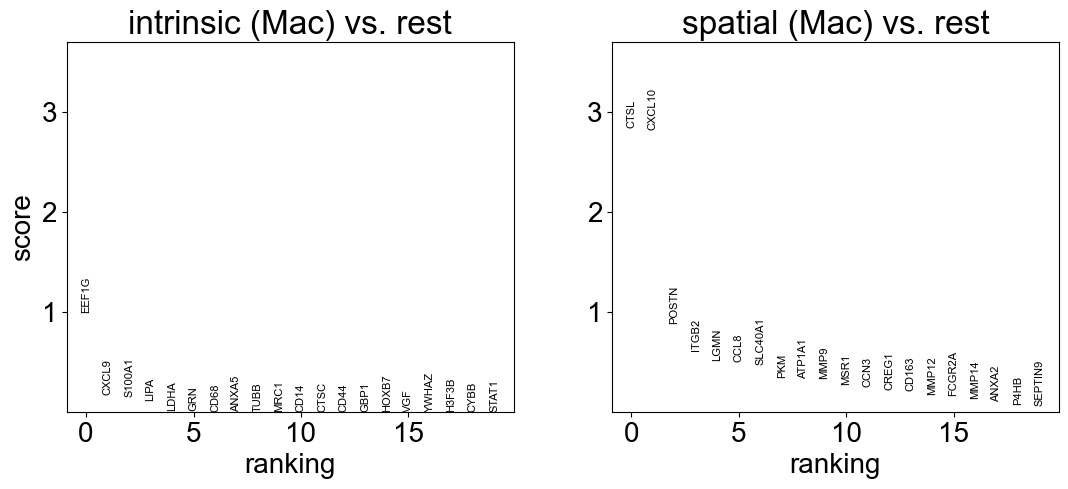

/nfs/team361/aa36/PythonEnvs_2/envinflowdec27/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


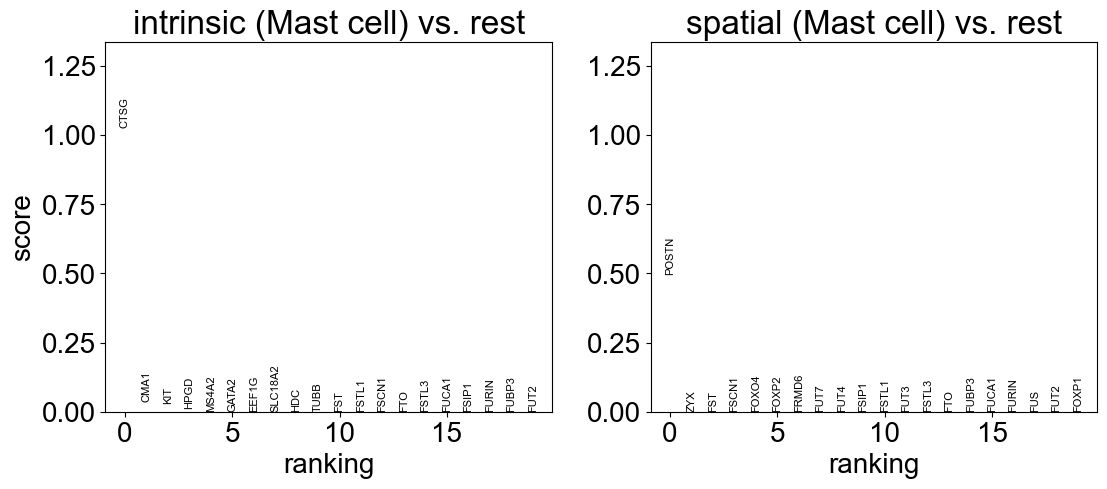

/nfs/team361/aa36/PythonEnvs_2/envinflowdec27/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


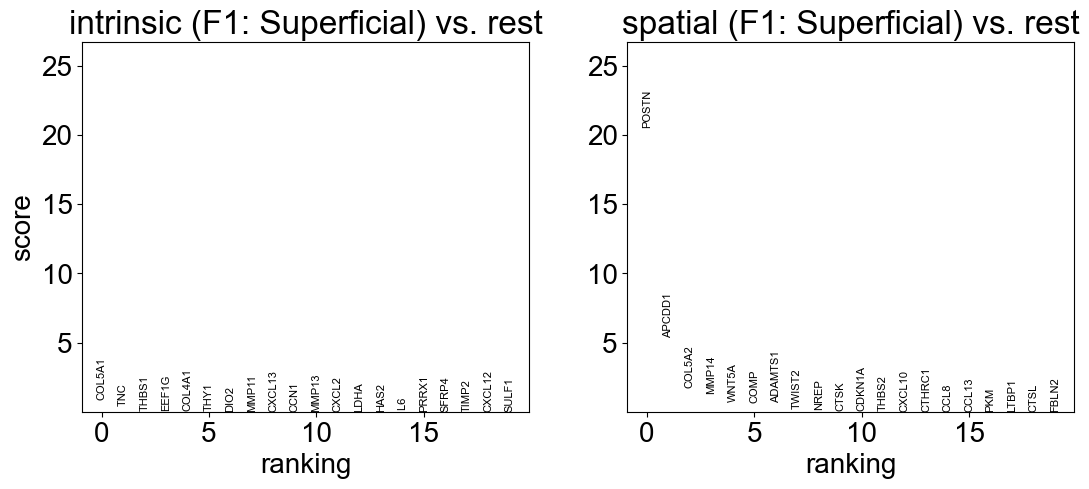

/nfs/team361/aa36/PythonEnvs_2/envinflowdec27/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


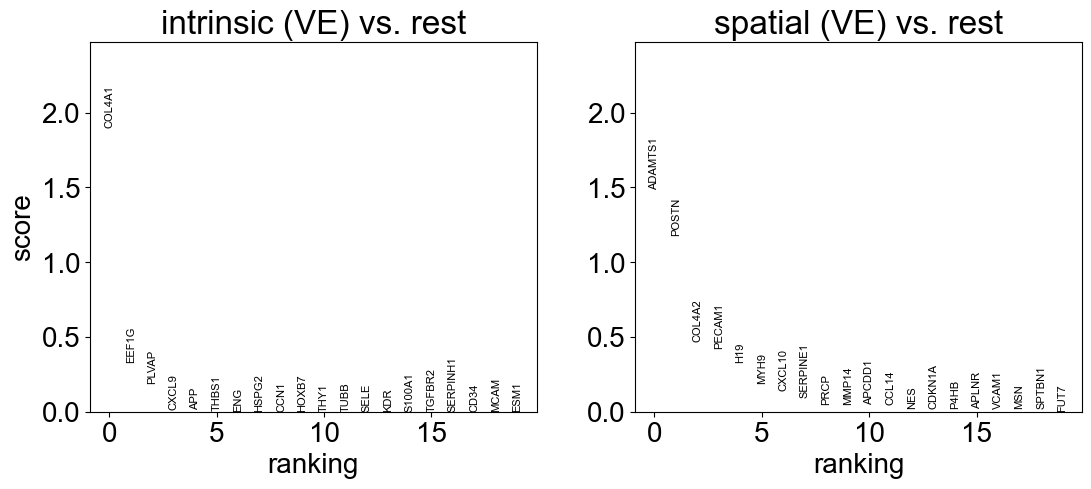

/nfs/team361/aa36/PythonEnvs_2/envinflowdec27/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


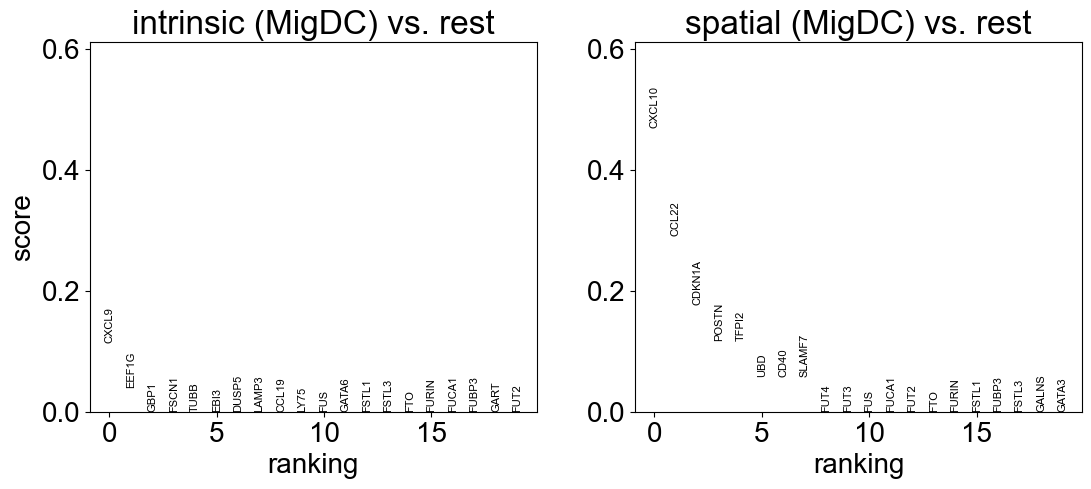

/nfs/team361/aa36/PythonEnvs_2/envinflowdec27/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


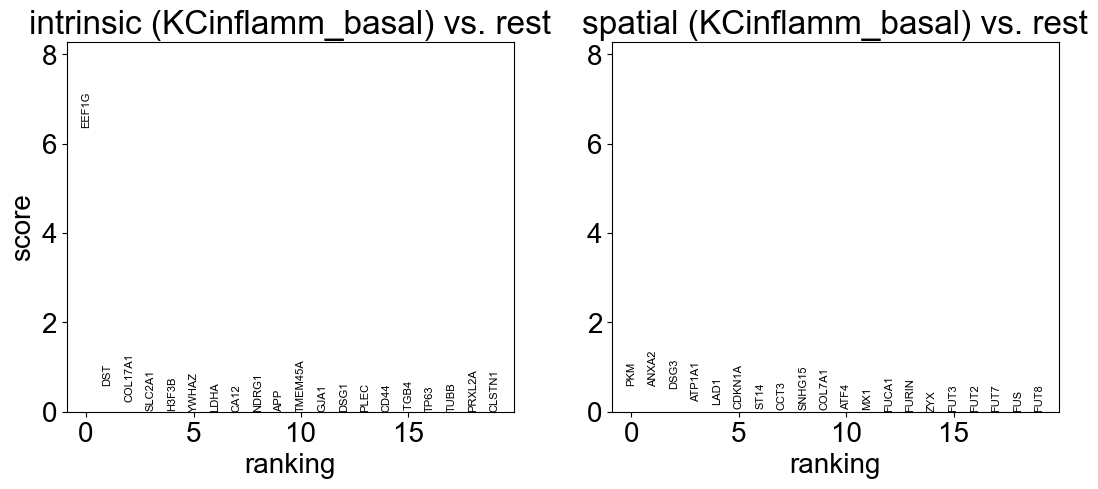

/nfs/team361/aa36/PythonEnvs_2/envinflowdec27/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nfs/team361/aa36/PythonEnvs_2/envinflowdec27/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:482: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin, ymax)


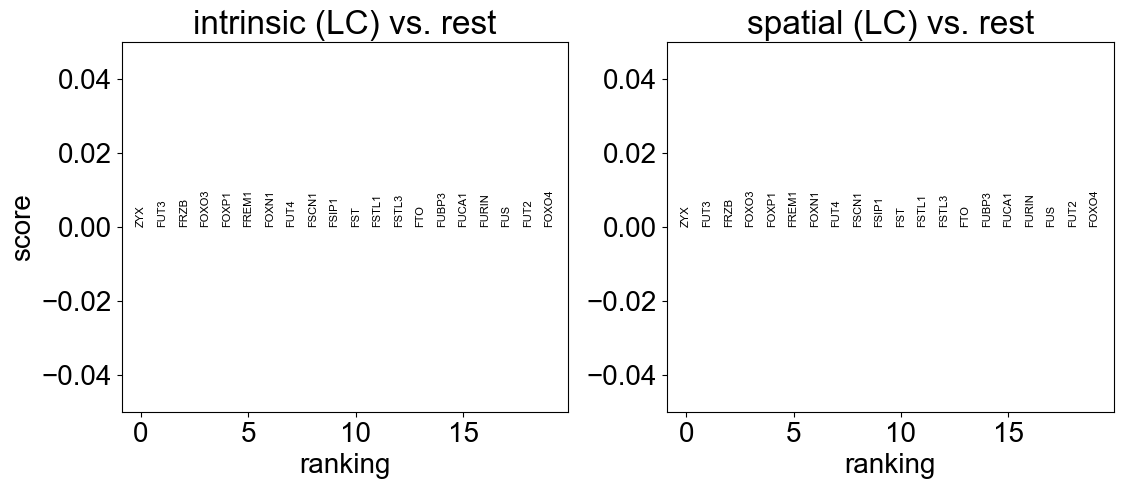

/nfs/team361/aa36/PythonEnvs_2/envinflowdec27/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


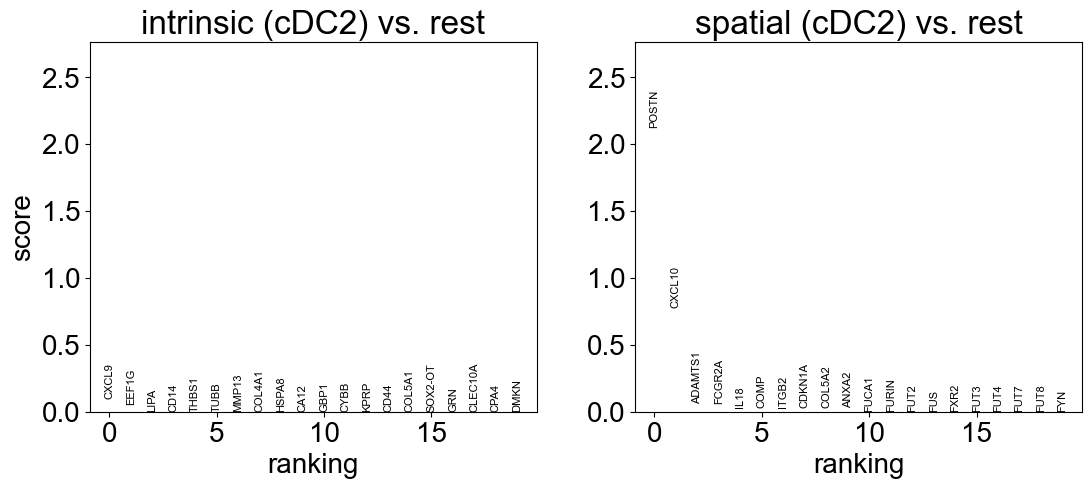

/nfs/team361/aa36/PythonEnvs_2/envinflowdec27/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


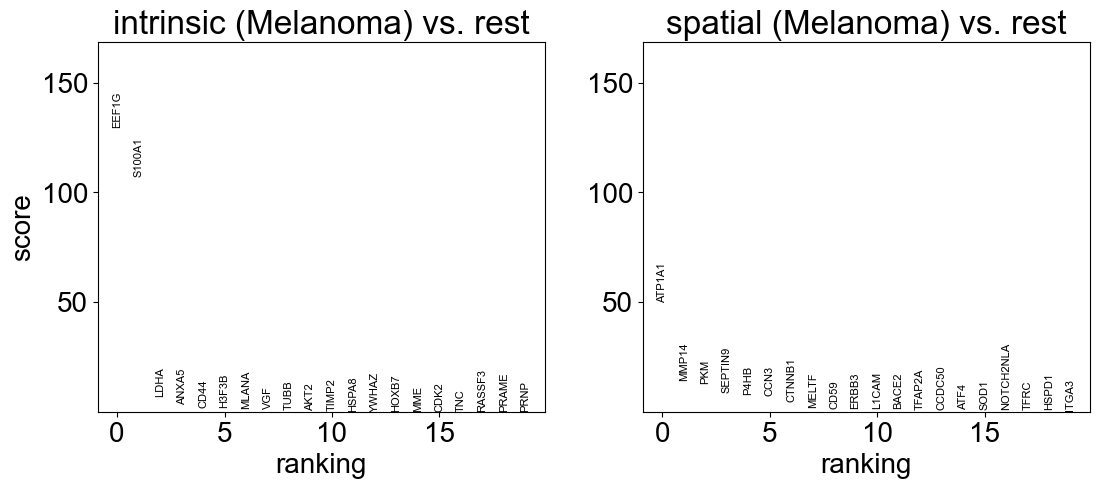

/nfs/team361/aa36/PythonEnvs_2/envinflowdec27/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


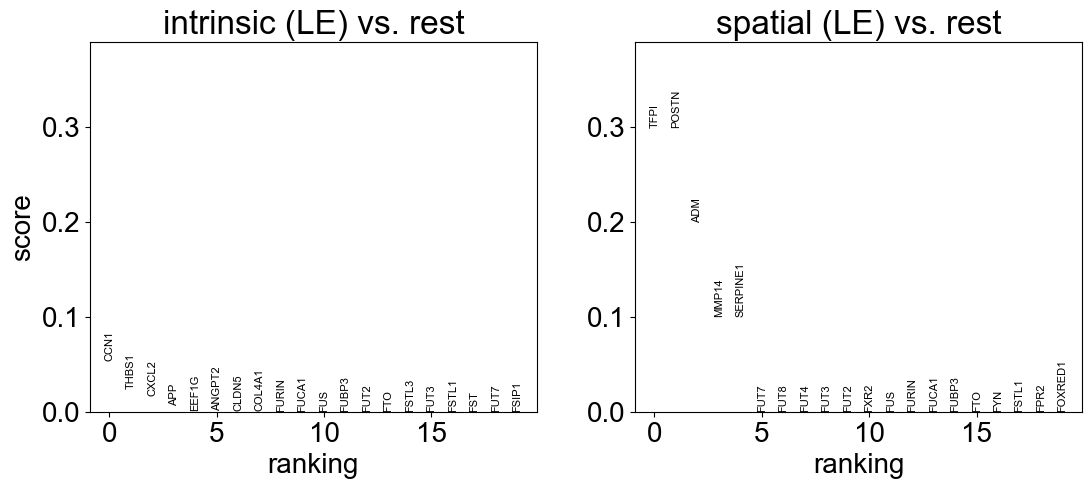

/nfs/team361/aa36/PythonEnvs_2/envinflowdec27/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


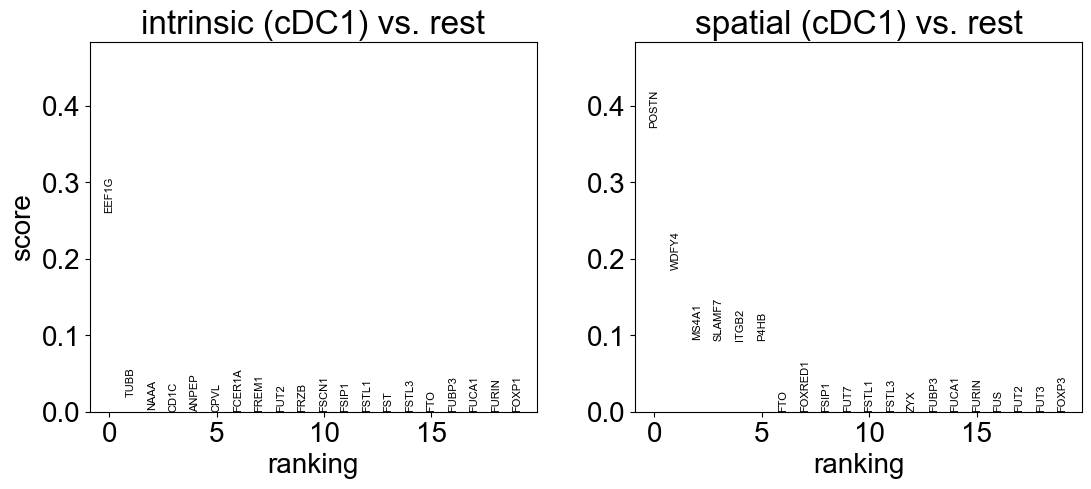

/nfs/team361/aa36/PythonEnvs_2/envinflowdec27/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


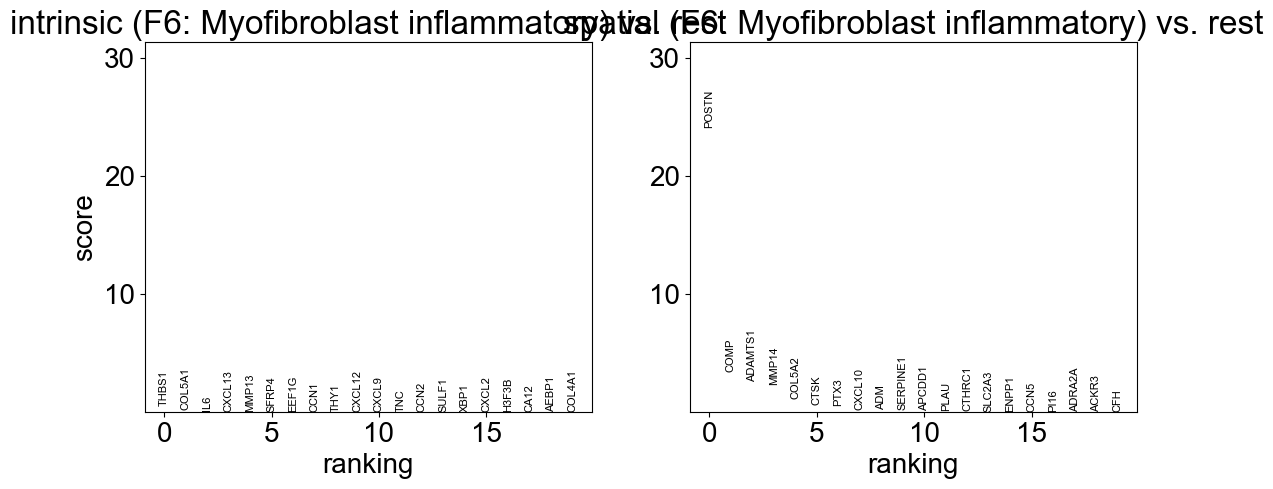

/nfs/team361/aa36/PythonEnvs_2/envinflowdec27/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


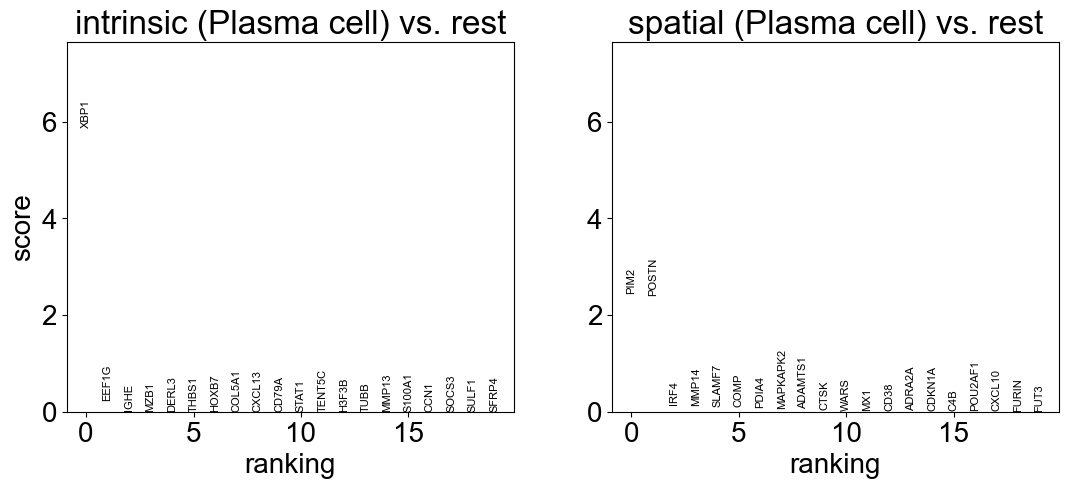

/nfs/team361/aa36/PythonEnvs_2/envinflowdec27/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


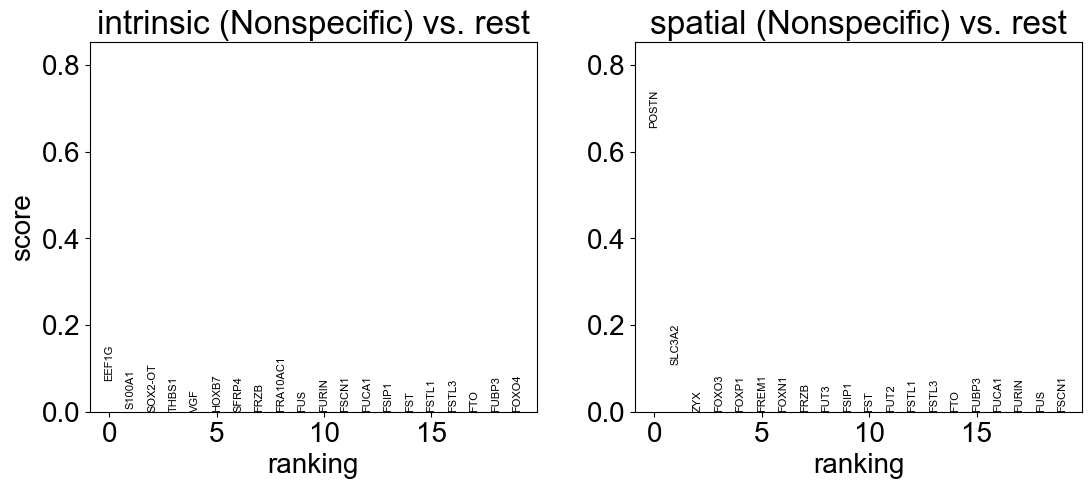

/nfs/team361/aa36/PythonEnvs_2/envinflowdec27/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


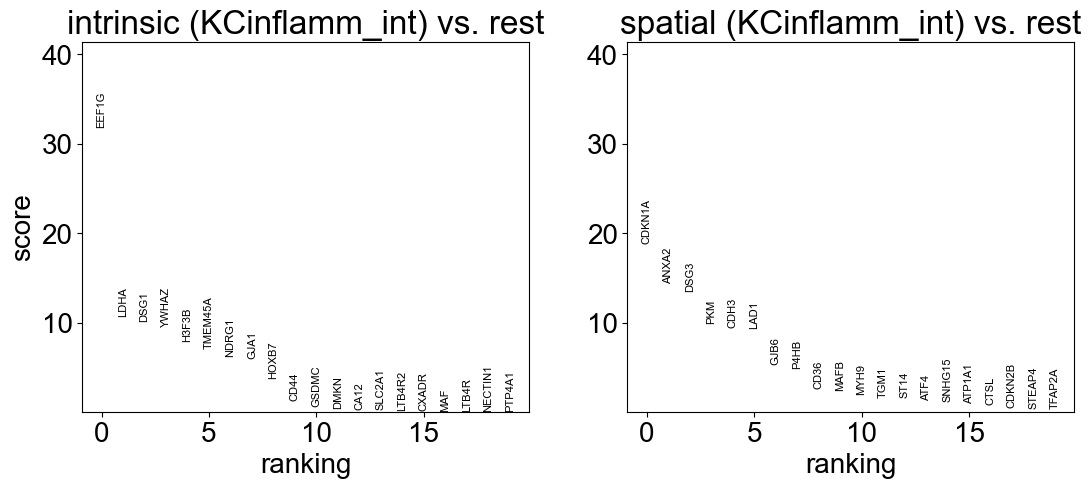

/nfs/team361/aa36/PythonEnvs_2/envinflowdec27/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


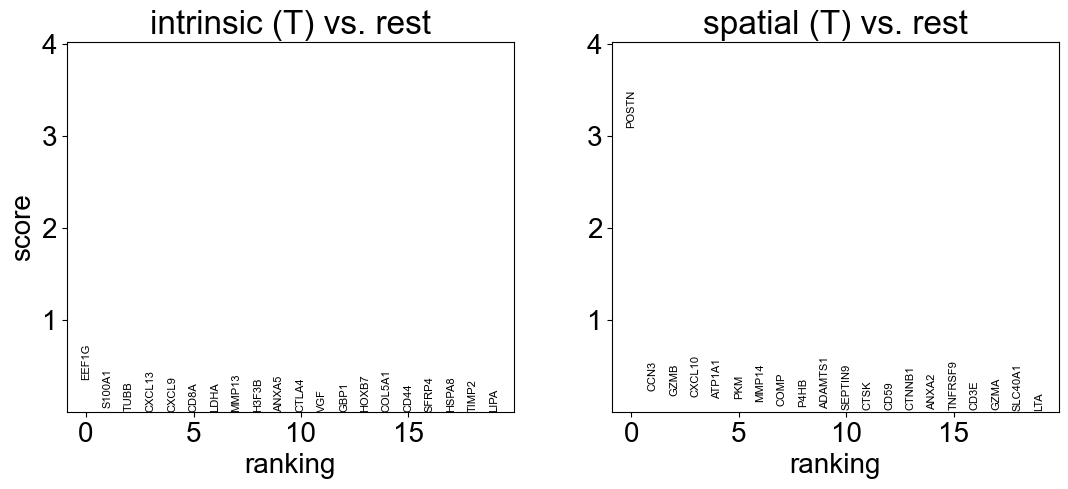

/nfs/team361/aa36/PythonEnvs_2/envinflowdec27/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


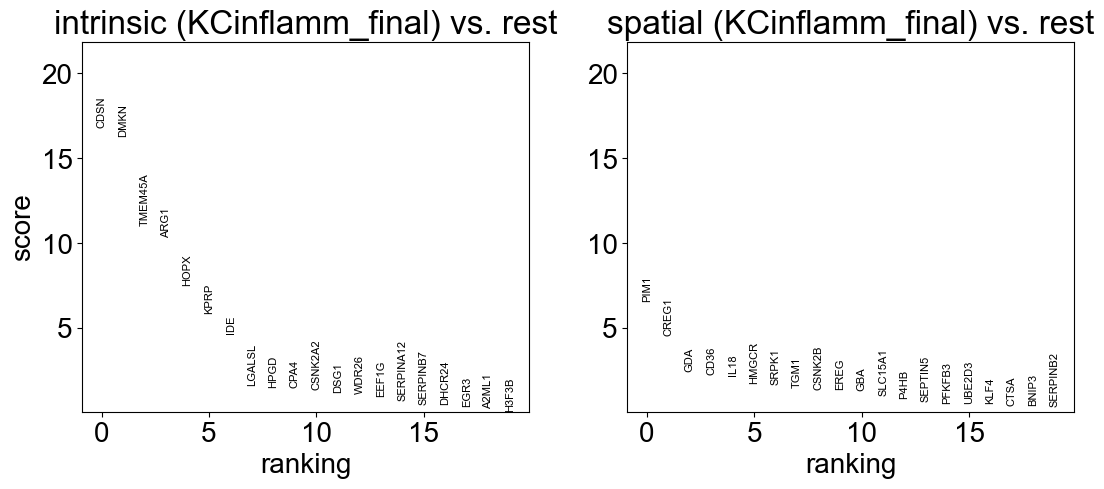

/nfs/team361/aa36/PythonEnvs_2/envinflowdec27/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


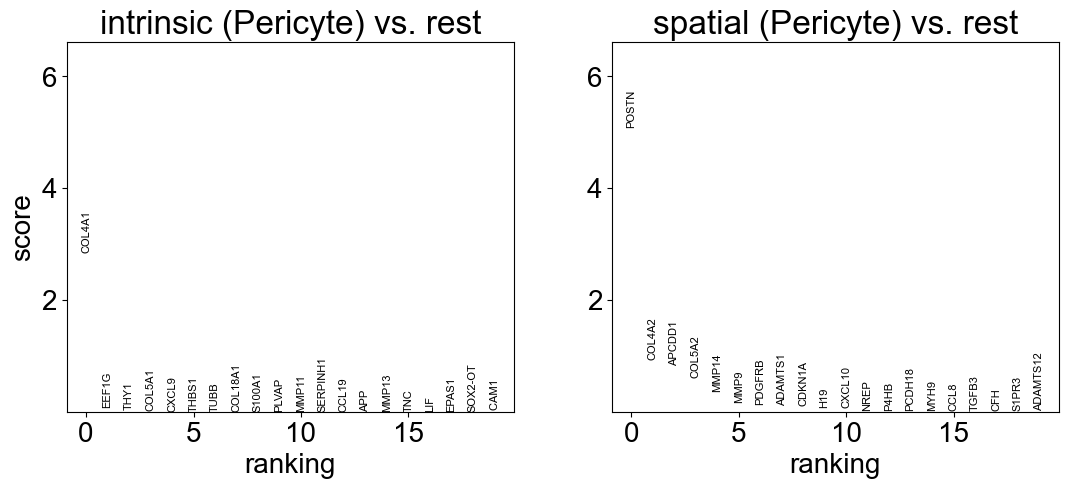

/nfs/team361/aa36/PythonEnvs_2/envinflowdec27/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


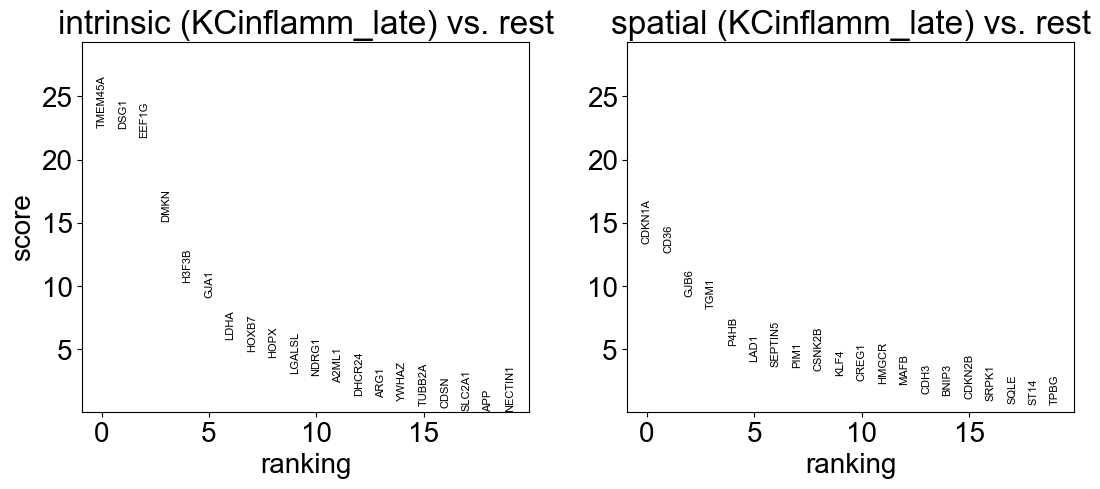

/nfs/team361/aa36/PythonEnvs_2/envinflowdec27/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


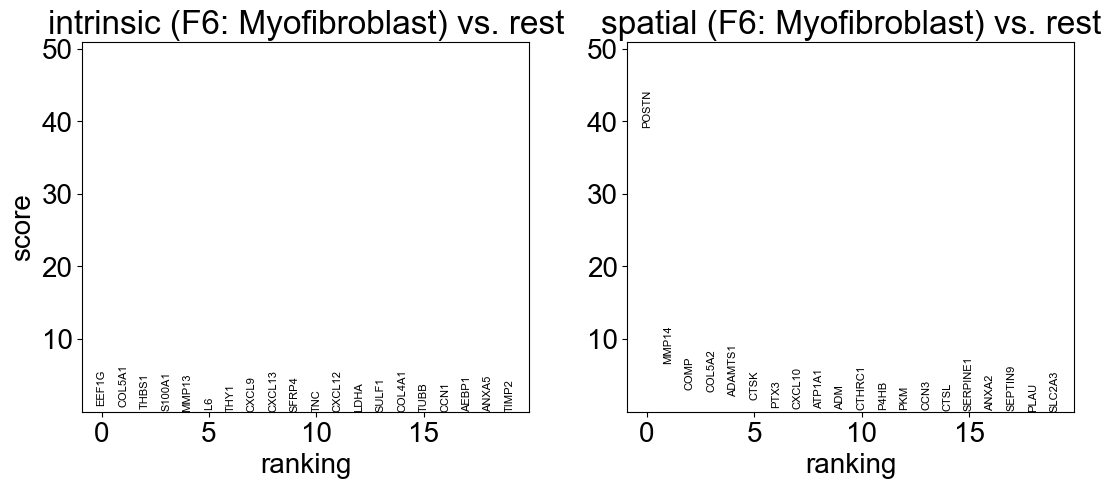

In [13]:
dict_ct_to_listmarker_ext, dict_ct_to_listmarker_int = {}, {}
key_celltype = config_data_test[0]['obskey_cell_type']
for ct in set(adata.obs[key_celltype]):
    l_filter_ct = (adata.obs[key_celltype] == ct).tolist()
    adata_ct = sc.AnnData(
        X=np.concatenate(
            [adata.obsm['inflow_Xint'][l_filter_ct, :], adata.obsm['inflow_Xspl'][l_filter_ct, :]],
            0
        ),
        obs=pd.DataFrame(
            data=np.array(
                [np.sum(l_filter_ct)*['intrinsic ({})'.format(ct)] + np.sum(l_filter_ct)*['spatial ({})'.format(ct)]]
            ).T,
            columns=['intrinsic_extrinsic']
        ),
        var=adata.var
    )

    if flag_logaritmise:
        sc.pp.log1p(adata_ct)

    sc.tl.rank_genes_groups(adata_ct, 'intrinsic_extrinsic', method='wilcoxon', n_genes=n_genes_showranking)
    sc.pl.rank_genes_groups(adata_ct)

    # grab the markers (to be used in the dot plots)
    dict_ct_to_listmarker_ext[ct] = [
        u[1] for u in adata_ct.uns['rank_genes_groups']['names'].tolist()
    ]
    dict_ct_to_listmarker_int[ct] = [
        u[0] for u in adata_ct.uns['rank_genes_groups']['names'].tolist()
    ]

## 3.2. Identify genes differentially expressed in the inferred instrinsic or spatial component 

<u>**Please Note**</u> The dotplots below are not visible in the notebook. To inspect them you can right click on each dot plot (while pressing the "Shift" key) and 
- Either select "Open Image in New Tab" (could be different in different browsers)
- Or select "Save Image As ..." (could be different in different browsers)

/nfs/team361/aa36/PythonEnvs_2/envinflowdec27/lib/python3.11/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 3863 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


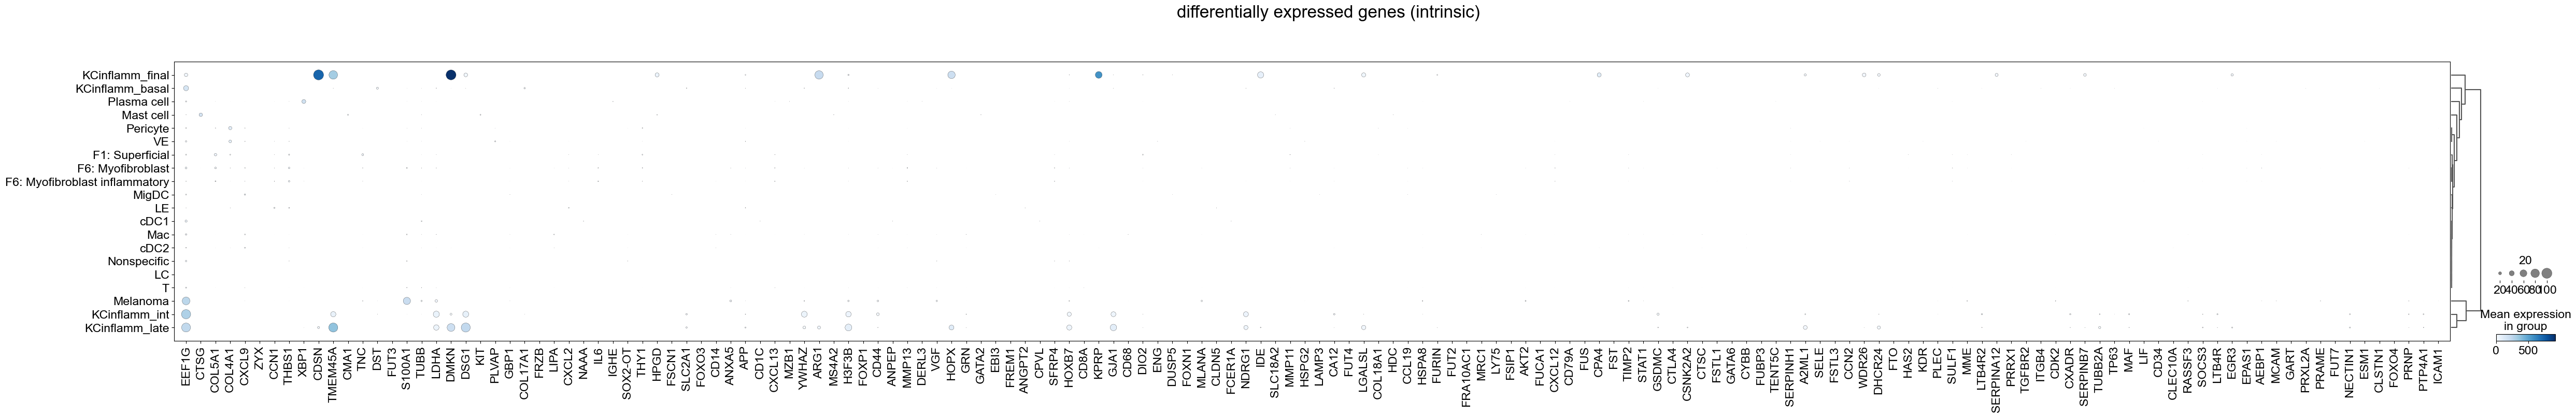

/nfs/team361/aa36/PythonEnvs_2/envinflowdec27/lib/python3.11/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 3863 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


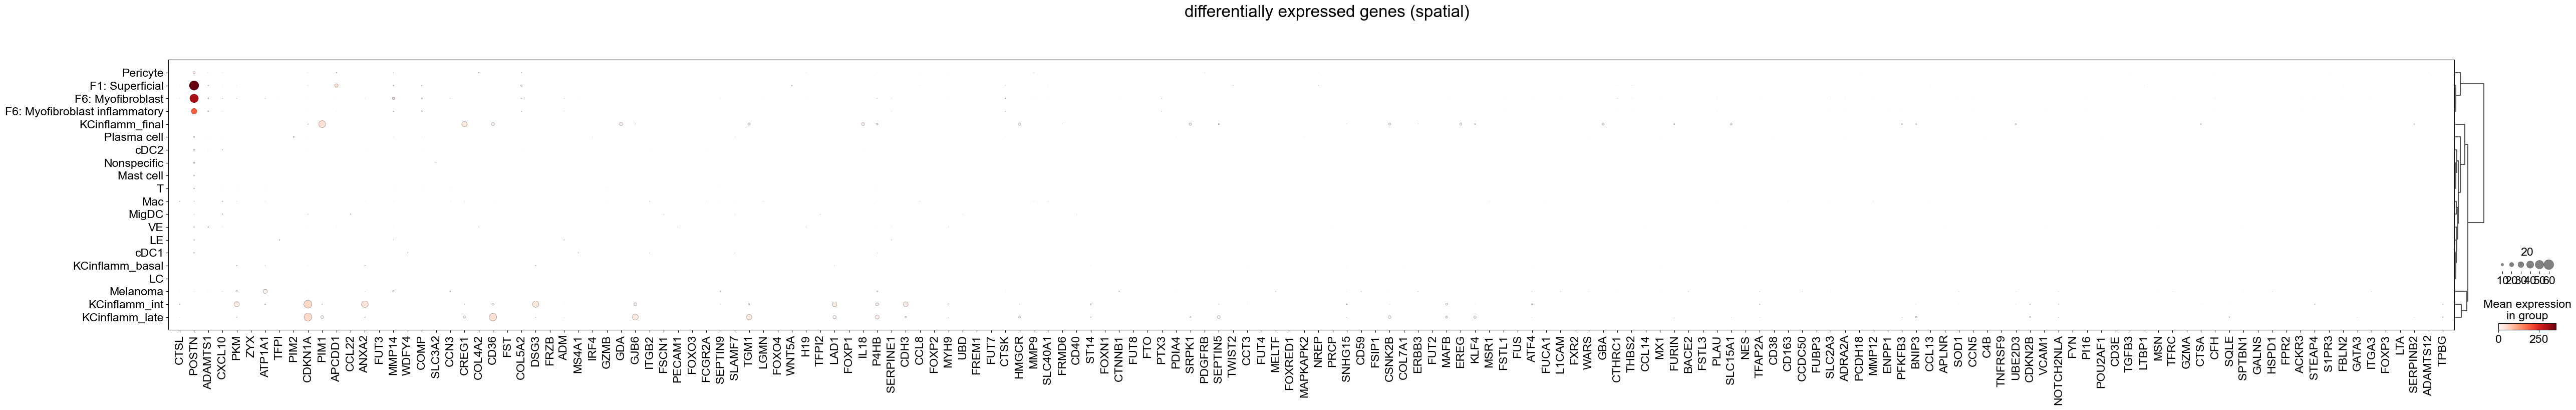

In [14]:
# show the dot plots for intrinsic and spatial markers
key_celltype = config_data_test[0]['obskey_cell_type']
for str_intorext in ['int', 'ext']:
    
    # get marker genes while keeping overall order (so they appear ordered in the dotplot)
    dict_markers = dict_ct_to_listmarker_int if(str_intorext=='int') else dict_ct_to_listmarker_ext
    list_markers = [dict_markers[ct] for ct in set(adata.obs[key_celltype])]
    list_markers = np.array(list_markers).flatten(order='F').tolist()

    set_markers_keeporder = []
    for u in list_markers:
        if u not in set_markers_keeporder:
            set_markers_keeporder.append(u)
    
    list_markers = set_markers_keeporder + []
    
    
    adata_dotplot = sc.AnnData(
        X=adata.obsm['inflow_Xint'] if(str_intorext=='int') else adata.obsm['inflow_Xspl'],
        var=adata.var,
        obs=adata.obs
    )
    sc.pl.dotplot(
        adata_dotplot,
        var_names=list_markers,
        groupby=key_celltype,
        dendrogram=True,
        title="differentially expressed genes ({})".format("intrinsic" if str_intorext=='int' else 'spatial'),
        size_title=20,
        cmap='Reds' if (str_intorext=='ext') else 'Blues'
    )

## 3.3. Compute and inspect the spatial signalling activity for each cell

Here for each cell we compute the proportion of its total read counts which are predicted as being spatially induced. 

More precisely, for the n-th cell with gene expression vector $\boldsymbol{X}_n$ we compute the following scalard between 0.0 and 1.0 $$\frac{\sum \boldsymbol{X^{spl}}_n}{\sum \boldsymbol{X}_n}$$

One can think of this number as the spatial signaling activity of the cell.


In [ ]:
adata.obs['inflow_signaling_activity'] = adata.obsm['inflow_Xspl'].sum(1)/(np.array(adata.X.sum(1)).flatten() + 0.0)

In [ ]:
sc.pl.spatial(
    adata,
    color=['inflow_signaling_activity'],
    spot_size=10.0,
    wspace=0.5,
    cmap='jet',
    title=['tissue colored by signalling activity'],
    colorbar_loc='bottom'
)

## 3.4. Evaluate the predicted Xspl via a database of known ligand-receptor pairs

We combine the database collection of ligand-receptor pairs in 
"Armingol, E., Officer, A., Harismendy, O. & Lewis, N.E. Deciphering cell-cell interactions and communication from gene expression. Nat Rev Genet 22, 71–88 (2021)", which is available online https://github.com/LewisLabUCSD/Ligand-Receptor-Pairs/tree/c0ce8167c20c2f5d1a3d309e04514da9a178c41c/Human 

Afterwards we use those genes to evalute Xspl predicted by inflow. Roughly speaking if a gene is in the database, its read counts should tend to be assigned to Xspl, and less frequently to Xint.

Please set the following variables below
- `violinplot_readtoun_equal_to`: Let's say this variable is set to 10. Then
  - The elements of `adata_unnorm.X` (i.e. the anndata **before** `sc.pp.normalize_total` is called) which are equal to 10 are selected.
  - A read count equal to 10 can be split between Xint and Xspl in differen ways:
    - 0 in Xint and 10 in Xspl.
    - 1 in Xint and 9 in Xspl.
    - 2 in Xint and 8 in Xspl.
    - ...
    - 9 in Xint and 1 in Xspl.
    - 10 in Xint and 0 in Xspl.
  - If that 10 read count is related to a gene in the ligand-receptor database, one would expect it should be split, e.g., 1 in Xint and 9 in Xspl and not the reverse. For such counts, their distribution of fraction assigned to Xspl (as seen in the violin plots) is expected to be skewed towards one, while for genes not in the ligand-receptor database it's expected to be skewed towards zero.    

As mentioned in the manuscript, this happens for a range of `violinplot_readtoun_equal_to` values bigger than a threshold.

In [ ]:
# local settings (TODO:modify if needed) ===
violinplot_readtoun_equal_to = 50


### 3.4.1. Load the ligand-receptor database

In [ ]:
df_LRpairs = pd.read_csv(
    os.path.join(
        rootdir_inflow,
        "cli",
        "Files2Use_CLI",
        "df_LRpairs_Armingoletal.txt"
    )
)
list_known_LRgenes_inDB = [
    genename
    for colname in ['LigName', 'RecName'] for group in df_LRpairs[colname].tolist() for genename in str(group).split("__")
]
list_known_LRgenes_inDB = set(list_known_LRgenes_inDB)
list_LR = []
for gene_name in adata.var.index.tolist():
    if gene_name in list_known_LRgenes_inDB:
        list_LR.append(gene_name)

print("Out of {} genes, {} were found in the ligand-receptor database.".format(
    adata.shape[1],
    len(list_LR)
))

### 3.4.2. Create violin plots for read counts equal to some value

In [ ]:
colsel_in_signaling_genes = adata.var.index.isin(list_LR)
mask_inLR  = adata_unnorm.X.toarray()[:, colsel_in_signaling_genes] == violinplot_readtoun_equal_to
mask_notinLR  = adata_unnorm.X.toarray()[:, ~colsel_in_signaling_genes] == violinplot_readtoun_equal_to
mask_all = adata_unnorm.X.toarray() == violinplot_readtoun_equal_to

curr_pred_inLR = adata.obsm['inflow_Xspl_without_scppnormalizetotal'][:, colsel_in_signaling_genes][mask_inLR].flatten()
curr_pred_notinLR = adata.obsm['inflow_Xspl_without_scppnormalizetotal'][:, ~colsel_in_signaling_genes][mask_notinLR].flatten()

plt.figure()
sns.violinplot(
    data={
        'not among known \n signaling genes': curr_pred_notinLR / (violinplot_readtoun_equal_to + 0.0),
        'among known \n signaling genes': curr_pred_inLR / (violinplot_readtoun_equal_to + 0.0),
    },
    cut=0
)
plt.title(
    "among elements of adata.X \n which are equal to {} \n population size left: {} \n population size right: {}".format(
        violinplot_readtoun_equal_to,
        curr_pred_notinLR.shape[0],
        curr_pred_inLR.shape[0]
    )
)
plt.ylabel("Fraction of the read count \n predicted as being in Xspl.")


### 3.4.2. Create violin plots for read counts >= some value

In [ ]:
colsel_in_signaling_genes = adata.var.index.isin(list_LR)
mask_inLR  = adata_unnorm.X.toarray()[:, colsel_in_signaling_genes] >= violinplot_readtoun_equal_to
mask_notinLR  = adata_unnorm.X.toarray()[:, ~colsel_in_signaling_genes] >= violinplot_readtoun_equal_to
mask_all = adata_unnorm.X.toarray() >= violinplot_readtoun_equal_to

curr_pred_inLR = adata.obsm['inflow_Xspl_without_scppnormalizetotal'][:, colsel_in_signaling_genes][mask_inLR].flatten()
curr_pred_notinLR = adata.obsm['inflow_Xspl_without_scppnormalizetotal'][:, ~colsel_in_signaling_genes][mask_notinLR].flatten()

plt.figure()
sns.violinplot(
    data={
        'not among known \n signaling genes': \
        curr_pred_notinLR /(adata_unnorm.X.toarray()[:, ~colsel_in_signaling_genes][mask_notinLR].flatten() + 0.0),
        'among known \n signaling genes': \
        curr_pred_inLR / (adata_unnorm.X.toarray()[:, colsel_in_signaling_genes][mask_inLR].flatten() + 0.0),
    },
    cut=0
)
plt.title(
    "among elements of adata.X \n which >= {} \n population size left: {} \n population size right: {}".format(
        violinplot_readtoun_equal_to,
        curr_pred_notinLR.shape[0],
        curr_pred_inLR.shape[0]
    )
)
plt.ylabel("Fraction of the read count \n predicted as being in Xspl.")
